<a href="https://colab.research.google.com/github/WarenWega/4A_ESIREM/blob/main/Copie_de_Template_TP_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Les deux premiers blocs du Notebook ne sont pas à modifier. Ils servent à la configuration du projet.

In [ ]:
# All the needed imports are already here
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, concatenate, IntegerLookup, Normalization, StringLookup
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [ ]:
# Mandatory pre-processing functions
# Converts a Pandas DataFram into a Keras Tensor Dataset
"""
    x:      Pandas Dataframe a dataframe containing all the subsets of data for the neural network
    y:      Pandas Dataframe a dataframe containing all the labels for each subsets of data
"""
def dataframe_to_dataset(x, y):
    train = x.copy()
    labels = y
    ds = tf.data.Dataset.from_tensor_slices((dict(train), labels))
    ds = ds.shuffle(buffer_size=len(train))
    return ds

# Converts a number input into an encoded tensor
"""
    feature:    any feature to encode
    name:       string name of the feature
    dataset:    Keras Tensor Dataset the dataset in which the feature is found
"""
def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)

    return encoded_feature

# Convert a categorical feature into an encoded tensor
"""
    feature:    any feature to encode
    name:       string name of the feature
    dataset:    Keras Tensor Dataset the dataset in which the feature is found
    is_string:  bool whether the feature is a string
"""
def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)

    return encoded_feature

Votre travail commence **ici**

In [ ]:
### TODO Import the dataset https://github.com/mwaskom/seaborn-data/raw/master/tips.csv using Pandas

data = pd.read_csv("https://github.com/mwaskom/seaborn-data/raw/master/tips.csv")

### TODO Split the Pandas Dataframe into 2 parts. The features (sex, smoker, day, etc.) will go into the variable x and the column tips will go into variable y
### Remember, what we want to predict is the value of the tip !

x = data.drop('tip', axis = 1)
y = data["tip"]
#print(x)

### TODO Instantiate one object of type Input() for each variable in your features (sex, smoker, day, etc...) but not the column tips
a = Input(shape=(1,),name=("sex"),dtype=(tf.string))
b = Input(shape=(1,),name=("smoker"),dtype=(tf.string))
c = Input(shape=(1,),name=("day"),dtype=(tf.string))
d = Input(shape=(1,),name=("time"),dtype=(tf.string))
e = Input(shape=(1,),name=("size"),dtype=(tf.int32))
f = Input(shape=(1,),name=("total_bill"),dtype=(tf.float32))

### In the constructor of Input(), set the shape to (1,), a name for your input, and the dtype of the input -> https://keras.io/api/layers/core_layers/input/
### If you do not know what a dtype is, you can always look at this -> https://www.oreilly.com/library/view/tensorflow-20-quick/9781789530759/851f368a-b0af-493d-a225-150e4c719e3c.xhtml

### TODO Put all of your previously instanciated inputs into a Python List called all_inputs

all_inputs = [a,b,c,d,e,f]





In [ ]:
# HYPERPARAMETERS GO HERE
NUMBER_OF_KFOLDS = 6
BATCH_SIZE = 1
NUMBER_OF_EPOCHS = 10
STARTING_LEARNING_RATE = 0.001

Epoch 1/10
203/203 [==============================] - 2s 4ms/step - loss: 6.5463 - accuracy: 0.0000e+00 - val_loss: 1.2840 - val_accuracy: 0.0000e+00
Epoch 2/10
203/203 [==============================] - 1s 3ms/step - loss: 1.4558 - accuracy: 0.0000e+00 - val_loss: 1.0755 - val_accuracy: 0.0000e+00
Epoch 3/10
203/203 [==============================] - 1s 3ms/step - loss: 1.2588 - accuracy: 0.0000e+00 - val_loss: 0.8972 - val_accuracy: 0.0000e+00
Epoch 4/10
203/203 [==============================] - 1s 3ms/step - loss: 1.1776 - accuracy: 0.0000e+00 - val_loss: 0.7769 - val_accuracy: 0.0000e+00
Epoch 5/10
203/203 [==============================] - 1s 3ms/step - loss: 1.1448 - accuracy: 0.0000e+00 - val_loss: 0.7619 - val_accuracy: 0.0000e+00
Epoch 6/10
203/203 [==============================] - 1s 3ms/step - loss: 1.1239 - accuracy: 0.0000e+00 - val_loss: 0.7882 - val_accuracy: 0.0000e+00
Epoch 7/10
203/203 [==============================] - 1s 3ms/step - loss: 1.1209 - accuracy: 0.0000e

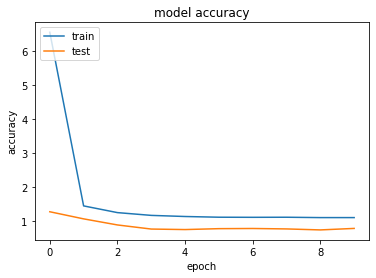

Epoch 1/10
203/203 [==============================] - 2s 4ms/step - loss: 4.7034 - accuracy: 0.0000e+00 - val_loss: 2.2698 - val_accuracy: 0.0000e+00
Epoch 2/10
203/203 [==============================] - 1s 3ms/step - loss: 1.5997 - accuracy: 0.0000e+00 - val_loss: 1.7968 - val_accuracy: 0.0000e+00
Epoch 3/10
203/203 [==============================] - 1s 3ms/step - loss: 1.2424 - accuracy: 0.0000e+00 - val_loss: 1.6174 - val_accuracy: 0.0000e+00
Epoch 4/10
203/203 [==============================] - 1s 3ms/step - loss: 1.0912 - accuracy: 0.0000e+00 - val_loss: 1.6160 - val_accuracy: 0.0000e+00
Epoch 5/10
203/203 [==============================] - 1s 3ms/step - loss: 0.9826 - accuracy: 0.0000e+00 - val_loss: 1.7153 - val_accuracy: 0.0000e+00
Epoch 6/10
203/203 [==============================] - 1s 3ms/step - loss: 0.9726 - accuracy: 0.0000e+00 - val_loss: 1.6132 - val_accuracy: 0.0000e+00
Epoch 7/10
203/203 [==============================] - 1s 3ms/step - loss: 0.9692 - accuracy: 0.0000e

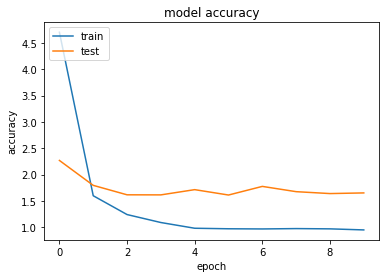

Epoch 1/10
203/203 [==============================] - 1s 4ms/step - loss: 2.5386 - accuracy: 0.0000e+00 - val_loss: 2.0292 - val_accuracy: 0.0000e+00
Epoch 2/10
203/203 [==============================] - 1s 3ms/step - loss: 1.1385 - accuracy: 0.0000e+00 - val_loss: 1.9736 - val_accuracy: 0.0000e+00
Epoch 3/10
203/203 [==============================] - 1s 3ms/step - loss: 1.1046 - accuracy: 0.0000e+00 - val_loss: 1.8184 - val_accuracy: 0.0000e+00
Epoch 4/10
203/203 [==============================] - 1s 3ms/step - loss: 1.0627 - accuracy: 0.0000e+00 - val_loss: 1.7211 - val_accuracy: 0.0000e+00
Epoch 5/10
203/203 [==============================] - 1s 3ms/step - loss: 1.0278 - accuracy: 0.0000e+00 - val_loss: 1.6790 - val_accuracy: 0.0000e+00
Epoch 6/10
203/203 [==============================] - 1s 3ms/step - loss: 1.0051 - accuracy: 0.0000e+00 - val_loss: 1.7870 - val_accuracy: 0.0000e+00
Epoch 7/10
203/203 [==============================] - 1s 3ms/step - loss: 1.0039 - accuracy: 0.0000e

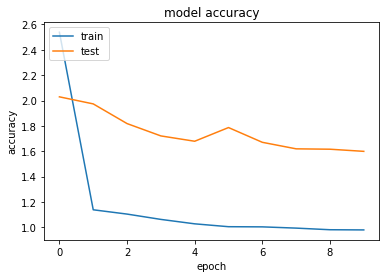

Epoch 1/10
203/203 [==============================] - 2s 4ms/step - loss: 3.2342 - accuracy: 0.0000e+00 - val_loss: 1.9676 - val_accuracy: 0.0000e+00
Epoch 2/10
203/203 [==============================] - 1s 3ms/step - loss: 1.3932 - accuracy: 0.0000e+00 - val_loss: 1.4510 - val_accuracy: 0.0000e+00
Epoch 3/10
203/203 [==============================] - 1s 3ms/step - loss: 1.2141 - accuracy: 0.0000e+00 - val_loss: 1.2676 - val_accuracy: 0.0000e+00
Epoch 4/10
203/203 [==============================] - 1s 3ms/step - loss: 1.1674 - accuracy: 0.0000e+00 - val_loss: 1.1844 - val_accuracy: 0.0000e+00
Epoch 5/10
203/203 [==============================] - 1s 3ms/step - loss: 1.1171 - accuracy: 0.0000e+00 - val_loss: 1.2042 - val_accuracy: 0.0000e+00
Epoch 6/10
203/203 [==============================] - 1s 3ms/step - loss: 1.1124 - accuracy: 0.0000e+00 - val_loss: 1.1155 - val_accuracy: 0.0000e+00
Epoch 7/10
203/203 [==============================] - 1s 3ms/step - loss: 1.0943 - accuracy: 0.0000e

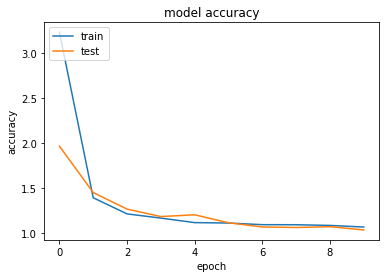

Epoch 1/10
204/204 [==============================] - 1s 4ms/step - loss: 4.1332 - accuracy: 0.0000e+00 - val_loss: 3.1735 - val_accuracy: 0.0000e+00
Epoch 2/10
204/204 [==============================] - 1s 2ms/step - loss: 1.8292 - accuracy: 0.0000e+00 - val_loss: 2.1309 - val_accuracy: 0.0000e+00
Epoch 3/10
204/204 [==============================] - 1s 3ms/step - loss: 1.4526 - accuracy: 0.0000e+00 - val_loss: 1.7594 - val_accuracy: 0.0000e+00
Epoch 4/10
 26/204 [==>...........................] - ETA: 0s - loss: 1.1646 - accuracy: 0.0000e+00

KeyboardInterrupt: ignored

In [ ]:
### TODO Create a variable best_model that is equal to None
best_model = None

### TODO Create a variable smallest_error that is equal to 999
smallest_error = 999

# Splits the dataset into an array of differently generated train/test subsets
kfold = KFold(n_splits=NUMBER_OF_KFOLDS, shuffle=True)
for train, test in kfold.split(x, y):
    train_dataset = dataframe_to_dataset(x.iloc[train], y.iloc[train])
    validation_dataset = dataframe_to_dataset(x.iloc[test], y.iloc[test])

    train_dataset = train_dataset.batch(BATCH_SIZE)
    validation_dataset = validation_dataset.batch(BATCH_SIZE)

    ### TODO Use either the function encode_categorical_feature or encode_numerical_feature on your previously created Input objects
    ### depending on what you think seems right
    sex_encoded = encode_categorical_feature(a, "sex", train_dataset, True)
    smoker_encoded = encode_categorical_feature(b, "smoker", train_dataset, True)
    day_encoded = encode_categorical_feature(c, "day", train_dataset, True)
    time_encoded = encode_categorical_feature(d, "time", train_dataset, True)
    total_bill_encoded =  encode_numerical_feature(f, "total_bill", train_dataset)
    size_encoded = encode_categorical_feature(e, "size", train_dataset , False)

    all_features = concatenate(
        [
            sex_encoded,
            smoker_encoded,
            day_encoded,
            time_encoded,
            total_bill_encoded,
            size_encoded
        ]
    )

    ### TODO Create your neural network
    # Create a first Dense layer that takes as input your array of all_features
    first_layer = tf.keras.layers.Dense(6,)(all_features)
    
    # Try to create a number of other layers here, see with your teacher how you can do that or refer to the course given by Mx naudin
    second_layer = tf.keras.layers.Dense(4,)(first_layer)
    third_layer = tf.keras.layers.Dense(2,)(second_layer)
    # Create an output layer called output that is a Dense layer with only 1 output (this will be the tip predicted)
    output = tf.keras.layers.Dense(1,)(third_layer)

    model = Model(all_inputs, output)
    All_lost = []
    # See https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile
    model.compile(
        # Choose an optimizer to use
        optimizer = tf.keras.optimizers.Adam(learning_rate=STARTING_LEARNING_RATE),
        # Choose a loss to use,
        loss = tf.keras.losses.MeanSquaredError(),
        # Choose a metric to track
        metrics=[
            tf.keras.metrics.Accuracy()
        ]
    )
    history = model.fit(train_dataset, epochs=NUMBER_OF_EPOCHS, validation_data=validation_dataset)
    scores = model.evaluate(validation_dataset, verbose=0)


    # summarize history for accuracy
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    ### TODO If scores[1] is less than the smallest_error variable, save your new best model in the best_model variable

    if scores[1] < smallest_error :
      best_model = model

In [ ]:
history.history

{'loss': [2.7730634212493896],
 'accuracy': [0.0],
 'val_loss': [2.793728828430176],
 'val_accuracy': [0.0]}

In [ ]:
# Time to evaluate the model using random data

samples = [{
    "total_bill": 1.,
    "sex": "Male",
    "smoker": "Yes",
    "day": "Mon",
    "time": "Lunch",
    "size": 1
},
{
    "total_bill": 16.99,
    "sex": "Female",
    "smoker": "No",
    "day": "Wed",
    "time": "Dinner",
    "size": 2
},
{
    "total_bill": 16.99,
    "sex": "Female",
    "smoker": "Yes",
    "day": "Wed",
    "time": "Dinner",
    "size": 2
},
{
    "total_bill": 10.45,
    "sex": "Male",
    "smoker": "No",
    "day": "Fri",
    "time": "Lunch",
    "size": 1
},
{
    "total_bill": 15.,
    "sex": "Female",
    "smoker": "Yes",
    "day": "Tue",
    "time": "Lunch",
    "size": 2
},
{
    "total_bill": 45.99,
    "sex": "Male",
    "smoker": "No",
    "day": "Sun",
    "time": "Lunch",
    "size": 4
}]

for sample in samples:
    input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
    predictions = best_model.predict(input_dict)
    print(f'Pour {sample}, on prédit un pourboire de ${predictions[0][0]:.2f}')